## Setup

### Imports

In [19]:
%matplotlib inline

from timeit import timeit

import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms

### Search for an accelerator

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Trained model pipeline

### Data extraction

In [2]:
# The output of torchvision datasets are PILImage images of range [0,1]. We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


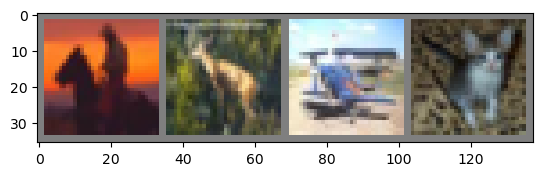

horse deer  plane cat  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Model defenition

In [23]:
class Net(nn.Module):
    def __init__(self, first_layer_nb_kernels=6):
        super().__init__()
        self.conv1 = nn.Conv2d(3, first_layer_nb_kernels, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(first_layer_nb_kernels, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

small_cpu_net = Net()
small_cuda_net = Net().cuda()
bigger_cpu_net = Net(32)
bigger_cuda_net = Net(32).cuda()

In [22]:
device

device(type='cuda', index=0)

### Train the network

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_model(net:Net):
    net_device = next(net.parameters()).device
    print(net_device)
    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            move_to_device = lambda x: x.to(device, non_blocking=True) if net_device.type == "cuda" else x
            inputs, labels = map(move_to_device, data)
                
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

%timeit train_model(small_cpu_net)
%timeit train_model(small_cuda_net)
%timeit train_model(bigger_cpu_net)
%timeit train_model(bigger_cuda_net)

cpu
[1,  2000] loss: 2.306
[1,  4000] loss: 2.305
[1,  6000] loss: 2.304
[1,  8000] loss: 2.306
[1, 10000] loss: 2.304
[1, 12000] loss: 2.304
[2,  2000] loss: 2.305
[2,  4000] loss: 2.305
[2,  6000] loss: 2.305
[2,  8000] loss: 2.305
[2, 10000] loss: 2.305
[2, 12000] loss: 2.305
Finished Training
cpu
[1,  2000] loss: 2.306
[1,  4000] loss: 2.306
[1,  6000] loss: 2.304
[1,  8000] loss: 2.305
[1, 10000] loss: 2.305
[1, 12000] loss: 2.305
[2,  2000] loss: 2.304
[2,  4000] loss: 2.305
[2,  6000] loss: 2.305
[2,  8000] loss: 2.305
[2, 10000] loss: 2.304
[2, 12000] loss: 2.306
Finished Training
cpu
[1,  2000] loss: 2.304
[1,  4000] loss: 2.304
[1,  6000] loss: 2.306
[1,  8000] loss: 2.305
[1, 10000] loss: 2.305
[1, 12000] loss: 2.306
[2,  2000] loss: 2.305
[2,  4000] loss: 2.305
[2,  6000] loss: 2.305
[2,  8000] loss: 2.305
[2, 10000] loss: 2.304
[2, 12000] loss: 2.305
Finished Training
cpu
[1,  2000] loss: 2.304
[1,  4000] loss: 2.304
[1,  6000] loss: 2.306
[1,  8000] loss: 2.306
[1, 10000]

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
#48.7 secs on the CPU

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

### Save model

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data
====================================

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


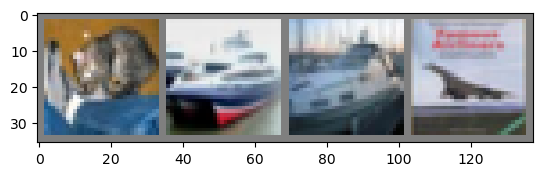

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   plane plane plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.7 %
Accuracy for class: car   is 70.6 %
Accuracy for class: bird  is 55.8 %
Accuracy for class: cat   is 51.8 %
Accuracy for class: deer  is 31.0 %
Accuracy for class: dog   is 28.3 %
Accuracy for class: frog  is 66.6 %
Accuracy for class: horse is 62.8 %
Accuracy for class: ship  is 54.9 %
Accuracy for class: truck is 58.6 %


## Conclusion

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
===============

Just like how you transfer a Tensor onto the GPU, you transfer the
neural net onto the GPU.

Let\'s first define our device as the first visible cuda device if we
have CUDA available:


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert
their parameters and buffers to CUDA tensors:

``` {.python}
net.to(device)
```

Remember that you will have to send the inputs and targets at every step
to the GPU too:

``` {.python}
inputs, labels = data[0].to(device), data[1].to(device)
```

Why don\'t I notice MASSIVE speedup compared to CPU? Because your
network is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first `nn.Conv2d`, and argument 1 of the second `nn.Conv2d` -- they
need to be the same number), see what kind of speedup you get.


Where do I go next?
===================

-   `Train neural nets to play video games </intermediate/reinforcement_q_learning>`{.interpreted-text
    role="doc"}
-   [Train a state-of-the-art ResNet network on
    imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
-   [Train a face generator using Generative Adversarial
    Networks](https://github.com/pytorch/examples/tree/master/dcgan)
-   [Train a word-level language model using Recurrent LSTM
    networks](https://github.com/pytorch/examples/tree/master/word_language_model)
-   [More examples](https://github.com/pytorch/examples)
-   [More tutorials](https://github.com/pytorch/tutorials)


In [ ]:
del dataiter